<a href="https://colab.research.google.com/github/BhardwajArjit/Causality-Informed-Segmentation/blob/main/Brain_MRI_Segformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook performs semantic segmentation on Brain MRI image dataset using  Segformer.

# 0. Get setup

In [ ]:
!pip install einops

import warnings
warnings.filterwarnings('ignore')

import os
import gc
from typing import List, Iterable

from IPython.display import clear_output
gc.enable()

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import StochasticDepth

from einops import rearrange

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from tqdm.notebook import tqdm
from glob import glob

seed = 42
pd.set_option('display.max_colwidth', None)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 916.9 kB/s eta 0:00:00


# 1. Get data

Link to the dataset: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation/data

In [ ]:
!pip install opendatasets
import opendatasets as od

od.download("https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: arjitdsce
Your Kaggle Key: ··········


100%|██████████| 714M/714M [00:07<00:00, 104MB/s]


# 2. Data exploration and preparation

In [ ]:
import os

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


In [ ]:
BATCH_SIZE = 8
IMAGE_SIZE = 224
EPOCHS = 10
NUM_CLASSES = 1

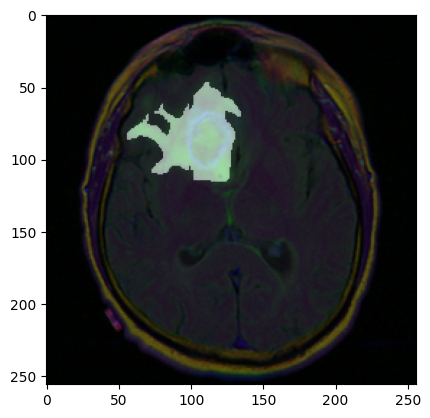

In [ ]:
mask = Image.open("/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif")
mask = np.array(mask)[..., np.newaxis]
mask = np.repeat(mask, 3, axis=-1)

image = Image.open("/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif")
image = np.array(image)

image = cv2.addWeighted(image, 0.5, mask, 0.5, 0)

plt.imshow(image)
plt.show()

In [ ]:
all_paths = glob("/content/lgg-mri-segmentation/kaggle_3m/*/*.tif")
images_paths = sorted([path for path in all_paths if "mask" not in path])
masks_paths = sorted([path[:-9] for path in all_paths if "mask" in path])
masks_paths = [path + "_mask.tif" for path in masks_paths]
del all_paths; gc.collect()

3335

In [ ]:
data = pd.DataFrame(data={"image": images_paths, "mask": masks_paths})

x_train, x_valid = train_test_split(data, test_size=500, shuffle=True, random_state=seed)
x_test, x_valid = train_test_split(x_valid, test_size=0.5, shuffle=True, random_state=seed)
x_train = x_train.reset_index(drop=True)
x_valid = x_valid.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

print(f"Train size: {x_train.shape[0]}, validation size: {x_valid.shape[0]}, test size: {x_test.shape[0]}")

Train size: 3429, validation size: 250, test size: 250


In [ ]:
x_train.sample(5)

,image,mask
578,/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_38.tif,/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_38_mask.tif
1055,/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_11.tif,/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_11_mask.tif
564,/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_40.tif,/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_40_mask.tif
2298,/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_14.tif,/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_14_mask.tif
3243,/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_44.tif,/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_44_mask.tif


In [ ]:
train_transforms = A.Compose([
                      A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2,
                                                    sat_shift_limit=0.2,
                                                    val_shift_limit=0.2,
                                                    p=0.2),
                      A.RandomBrightnessContrast(brightness_limit=0.2,
                                                 contrast_limit=0.2,
                                                 p=0.9)],p=0.2),
                      A.ToGray(p=0.1),
                      A.OneOf(
                              [A.HorizontalFlip(p=0.5),
                               A.VerticalFlip(p=0.5),
                               A.RandomRotate90(p=0.5),
                               A.Transpose(p=0.5),
                              ], p=0.5),
                      A.OneOf([
                                A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                                A.GridDistortion(p=0.5),
                                A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
                            ], p=0.8),
                      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
                      A.Cutout(num_holes=8, max_h_size=10, max_w_size=10, fill_value=0, p=0.1),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

valid_transforms = A.Compose([
                      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

invTrans = A.Compose([A.Normalize(mean=[ 0., 0., 0. ],
                                  std=[ 1/0.229, 1/0.224, 1/0.225 ], max_pixel_value=1.0),
                      A.Normalize(mean=[ -0.485, -0.456, -0.406 ],
                                  std=[ 1., 1., 1. ], max_pixel_value=1.0),
                      ], p=1.0)

def inverse_transforms(tensor):
    if tensor.size(0) == 1 and len(tensor.shape) == 4:
        tensor.squeeze_(0)
    sample = {"image": tensor.cpu().detach().numpy().transpose(1,2,0)}
    image = invTrans(**sample)["image"]

    return image

In [ ]:
class SegDataset(Dataset):
    def __init__(self, data, transforms):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, ix):
        row = self.data.loc[ix].squeeze()
        image = Image.open(row["image"])
        image = np.array(image)

        mask = Image.open(row["mask"])
        mask = np.array(mask)

        mask = np.where(mask > 127, 255, 0)

        sample = {"image": image, "mask": mask}
        sample = self.transforms(**sample)

        image, mask = sample["image"], sample["mask"]
        mask = mask[None, ...]

        return image, mask / 255.

    def collate_fn(self, batch):
        images, masks = list(zip(*batch))
        images, masks = [[tensor[None].to(device) for tensor in btc] for btc in [images, masks]]
        images, masks = [torch.cat(tensors) for tensors in [images, masks]]
        return images, masks

In [ ]:
train_ds = SegDataset(x_train, train_transforms)
valid_ds = SegDataset(x_valid, valid_transforms)
test_ds = SegDataset(x_test, valid_transforms)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=valid_ds.collate_fn)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=test_ds.collate_fn)

# 3. Segformer

In [ ]:
class LayerNorm2d(nn.LayerNorm):
    """ swap channel dim, apply layer norm and swap back: see https://github.com/pytorch/pytorch/issues/71465 """
    def forward(self, x):
        x = rearrange(x, "b c h w -> b h w c")
        x = super().forward(x)
        x = rearrange(x, "b h w c -> b c h w")
        return x

class OverlapPatchMerging(nn.Sequential):
    def __init__(
        self, in_channels: int, out_channels: int, patch_size: int, overlap_size: int
    ):
        super(OverlapPatchMerging, self).__init__(
                                        nn.Conv2d(
                                            in_channels,
                                            out_channels,
                                            kernel_size=patch_size,
                                            stride=overlap_size,
                                            padding=patch_size // 2,
                                            bias=False
                                        ),
                                        LayerNorm2d(out_channels)
                                    )

In [ ]:
# positional encoding eliminated as for original paper: https://arxiv.org/pdf/2105.15203.pdf

class EfficientMultiHeadAttention(nn.Module):
    def __init__(self, channels: int, reduction_ratio: int = 1, num_heads: int = 8):
        super(EfficientMultiHeadAttention, self).__init__()
        self.reducer = nn.Sequential(
            nn.Conv2d(
                channels, channels, kernel_size=reduction_ratio, stride=reduction_ratio
            ),
            LayerNorm2d(channels),
        )
        self.att = nn.MultiheadAttention(
            channels, num_heads=num_heads, batch_first=True
        )

    def forward(self, x):
        _, _, h, w = x.shape
        reduced_x = self.reducer(x)
        # attention needs tensor of shape (batch, sequence_length, channels)
        reduced_x = rearrange(reduced_x, "b c h w -> b (h w) c")  # K, V
        x = rearrange(x, "b c h w -> b (h w) c")  # Q
        out = self.att(query=x, key=reduced_x, value=reduced_x)[0]
        # reshape it back to (batch, channels, height, width)
        out = rearrange(out, "b (h w) c -> b c h w", h=h, w=w)
        return out

# transformer FFN block, here fully convolutional

class MixMLP(nn.Sequential):
    def __init__(self, channels: int, expansion: int = 4):
        super(MixMLP, self).__init__(
            # linear layer
            nn.Conv2d(channels, channels, kernel_size=1),
            # depth wise conv
            nn.Conv2d(
                    channels,
                    channels * expansion,
                    kernel_size=3,
                    groups=channels,
                    padding=1,
            ),
            nn.GELU(),
            # linear layer
            nn.Conv2d(channels * expansion, channels, kernel_size=1),
        )

In [ ]:
class ResidualAdd(nn.Module):
    """ A layer that helps to add&norm MHA and FFN outputs """
    def __init__(self, fn):
        super(ResidualAdd, self).__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        out = self.fn(x, **kwargs)
        x = x + out
        return x

class SegFormerEncoderBlock(nn.Sequential):
    """ Encoder Block: not quite orthodox as not normalizing after MHA and FFN directly """
    def __init__(
                self,
                channels: int,
                reduction_ratio: int = 1,
                num_heads: int = 8,
                mlp_expansion: int = 4,
                drop_path_prob: float = .0
            ):
        super(SegFormerEncoderBlock, self).__init__(
            ResidualAdd(
                nn.Sequential(
                    LayerNorm2d(channels),
                    EfficientMultiHeadAttention(channels, reduction_ratio, num_heads),
                )
            ),
            ResidualAdd(
                nn.Sequential(
                    LayerNorm2d(channels),
                    MixMLP(channels, expansion=mlp_expansion),
                    StochasticDepth(p=drop_path_prob, mode="batch")
                )
            ),
        )

In [ ]:
class SegFormerEncoderStage(nn.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        patch_size: int,
        overlap_size: int,
        drop_probs: List[int],
        depth: int = 2,
        reduction_ratio: int = 1,
        num_heads: int = 8,
        mlp_expansion: int = 4,
    ):
        super(SegFormerEncoderStage, self).__init__()
        self.overlap_patch_merge = OverlapPatchMerging(
            in_channels, out_channels, patch_size, overlap_size,
        )
        self.blocks = nn.Sequential(
            *[
                SegFormerEncoderBlock(
                    out_channels, reduction_ratio, num_heads, mlp_expansion, drop_probs[i]
                )
                for i in range(depth)
            ]
        )
        self.norm = LayerNorm2d(out_channels)

In [ ]:
def chunks(data: Iterable, sizes: List[int]):
    """
    Given an iterable, returns slices using sizes as indices
    """
    curr = 0
    for size in sizes:
        chunk = data[curr: curr + size]
        curr += size
        yield chunk

class SegFormerEncoder(nn.Module):
    def __init__(
        self,
        in_channels: int,
        widths: List[int],
        depths: List[int],
        all_num_heads: List[int],
        patch_sizes: List[int],
        overlap_sizes: List[int],
        reduction_ratios: List[int],
        mlp_expansions: List[int],
        drop_prob: float = .0
    ):
        super(SegFormerEncoder, self).__init__()
        # create drop paths probabilities (one for each stage's block)
        drop_probs =  [x.item() for x in torch.linspace(0, drop_prob, sum(depths))]
        self.stages = nn.ModuleList(
            [
                SegFormerEncoderStage(*args)
                for args in zip(
                    [in_channels, *widths],
                    widths,
                    patch_sizes,
                    overlap_sizes,
                    chunks(drop_probs, sizes=depths),
                    depths,
                    reduction_ratios,
                    all_num_heads,
                    mlp_expansions
                )
            ]
        )

    def forward(self, x):
        features = []
        for stage in self.stages:
            x = stage(x)
            features.append(x)
        return features

In [ ]:
class SegFormerDecoderBlock(nn.Sequential):
    """ upsample """
    def __init__(self, in_channels: int, out_channels: int, scale_factor: int = 2):
        super(SegFormerDecoderBlock, self).__init__(
            nn.UpsamplingBilinear2d(scale_factor=scale_factor),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
        )

class SegFormerDecoder(nn.Module):
    """ takes a list of features and returns a list of new features with the same spatial size and channels """
    def __init__(self, out_channels: int, widths: List[int], scale_factors: List[int]):
        super(SegFormerDecoder, self).__init__()
        self.stages = nn.ModuleList(
            [
                SegFormerDecoderBlock(in_channels, out_channels, scale_factor)
                for in_channels, scale_factor in zip(widths, scale_factors)
            ]
        )

    def forward(self, features):
        new_features = []
        for feature, stage in zip(features,self.stages):
            x = stage(feature)
            new_features.append(x)
        return new_features

In [ ]:
class SegFormerSegmentationHead(nn.Module):
    def __init__(self, channels: int, num_classes: int, num_features: int = 4):
        super(SegFormerSegmentationHead, self).__init__()
        self.fuse = nn.Sequential(
            nn.Conv2d(channels * num_features, channels, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(channels)
        )
        self.predict = nn.Conv2d(channels, num_classes, kernel_size=1)

    def forward(self, features):
        x = torch.cat(features, dim=1)
        x = self.fuse(x)
        x = self.predict(x)
        return x

In [ ]:
class SegFormer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        widths: List[int],
        depths: List[int],
        all_num_heads: List[int],
        patch_sizes: List[int],
        overlap_sizes: List[int],
        reduction_ratios: List[int],
        mlp_expansions: List[int],
        decoder_channels: int,
        scale_factors: List[int],
        num_classes: int,
        drop_prob: float = 0.0,
    ):

        super(SegFormer, self).__init__()
        self.encoder = SegFormerEncoder(
            in_channels,
            widths,
            depths,
            all_num_heads,
            patch_sizes,
            overlap_sizes,
            reduction_ratios,
            mlp_expansions,
            drop_prob,
        )
        self.decoder = SegFormerDecoder(decoder_channels, widths[::-1], scale_factors)
        self.head = SegFormerSegmentationHead(
            decoder_channels, num_classes, num_features=len(widths)
        )

    def forward(self, x):
        features = self.encoder(x)
        features = self.decoder(features[::-1])
        segmentation = self.head(features)
        return segmentation

In [ ]:
segformer = SegFormer(
    in_channels=3,
    widths=[64, 128, 256, 512],
    depths=[3, 4, 6, 3],
    all_num_heads=[1, 2, 4, 8],
    patch_sizes=[7, 3, 3, 3],
    overlap_sizes=[4, 2, 2, 2],
    reduction_ratios=[8, 4, 2, 1],
    mlp_expansions=[4, 4, 4, 4],
    decoder_channels=256,
    scale_factors=[8, 4, 2, 1],
    num_classes=NUM_CLASSES,
)

segmentation = segformer(torch.randn((1, 3, 224, 224)))
segmentation.shape # torch.Size([1, 2, 56, 56])

torch.Size([1, 1, 56, 56])

In [ ]:
def train_one_batch(data, model, optimizer, criterion, threshold=0.5):
    model.train()
    images, masks = data

    optimizer.zero_grad()
    out = model(images)  # [B, 1, 56, 56]
    out = nn.functional.interpolate(out, size=masks.shape[-2:], mode="bilinear", align_corners=False)  # [B, 1, 224, 224]

    loss = criterion(out, masks)  # [B, 1, 224, 224] of logits and [B, 1, 224, 224] of float zeros and ones

    loss.backward()
    optimizer.step()

    out = (torch.sigmoid(out) >= threshold).to(torch.float32)
    mask_accuracy = (out == masks).float().mean()  # binary accuracy

    return loss.item(), mask_accuracy.item()

# nn.CrossEntropyLoss()(torch.randn(8,2,224,224), msk.squeeze(1).long())  # [B, 2, 224, 224] and [B, 224, 224]

@torch.no_grad()
def validate_one_batch(data, model, criterion, threshold=0.5):
    model.eval()
    images, masks = data
    out = model(images)
    out = nn.functional.interpolate(out, size=masks.shape[-2:], mode="bilinear", align_corners=False)

    loss = criterion(out, masks)

    out = (torch.sigmoid(out) >= threshold).to(torch.float32)
    mask_accuracy = (out == masks).float().mean()

    return loss.item(), mask_accuracy.item()

@torch.no_grad()
def test_plot(model):
    model.eval()
    idx = np.random.randint(len(x_test))
    image = Image.open(x_test.iloc[idx, 0]).resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.array(image)
    sample = {"image": image}
    inputs = valid_transforms(**sample)["image"].unsqueeze(0).to(device)

    mask = Image.open(x_test.iloc[idx, 1]).resize((IMAGE_SIZE, IMAGE_SIZE))
    mask = np.array(mask)[..., np.newaxis]
    mask = np.repeat(mask, 3, axis=-1)

    masked_image = cv2.addWeighted(image, 0.5, mask, 0.5, 0)

    out = model(inputs)
    out = nn.functional.interpolate(out, size=(IMAGE_SIZE, IMAGE_SIZE), mode="bilinear", align_corners=False)
    out = torch.sigmoid(out)
    out = out.detach().cpu().numpy()[0].transpose(1,2,0)
    out = np.where(out >= 0.5, 1, 0)
    out = np.clip(out * 255, 0, 255)
    out = np.repeat(out, 3, axis=-1).astype(np.uint8)

    out_image = cv2.addWeighted(image, 0.5, out, 0.5, 0)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[1].imshow(masked_image)
    axes[1].set_title("Original Mask")
    axes[2].imshow(out_image)
    axes[2].set_title("Predicted Mask")
    plt.tight_layout()
    plt.show()

In [ ]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0, path='model.pth'):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model=None):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            checkpoint = {
                'model': model,
            }
            torch.save(checkpoint, self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [ ]:
model = SegFormer(
                in_channels=3,
                widths=[64, 128, 256, 512],
                depths=[3, 4, 6, 3],
                all_num_heads=[1, 2, 4, 8],
                patch_sizes=[7, 3, 3, 3],
                overlap_sizes=[4, 2, 2, 2],
                reduction_ratios=[8, 4, 2, 1],
                mlp_expansions=[4, 4, 4, 4],
                decoder_channels=256,
                scale_factors=[8, 4, 2, 1],
                num_classes=NUM_CLASSES,
                                        ).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.00005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-7, factor=0.1)
stopper = EarlyStopping(patience=8)

In [ ]:
print_feq = 100

# 4. Training

epoch: 1 	step: 1 / 430 	train loss: 0.7080 	train accuracy: 0.4896 	time: 2019.3300 s
epoch: 1 	step: 101 / 430 	train loss: 0.6358 	train accuracy: 0.8807 	time: 15.5632 s
epoch: 1 	step: 201 / 430 	train loss: 0.5731 	train accuracy: 0.9760 	time: 15.4003 s
epoch: 1 	step: 301 / 430 	train loss: 0.4748 	train accuracy: 0.9949 	time: 15.7240 s
epoch: 1 	step: 401 / 430 	train loss: 0.3891 	train accuracy: 0.9957 	time: 16.0733 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 1 / 11 	train loss: 0.5456 	valid loss: 0.3680 	train accuracy 0.9144 	valid accuracy 0.9843


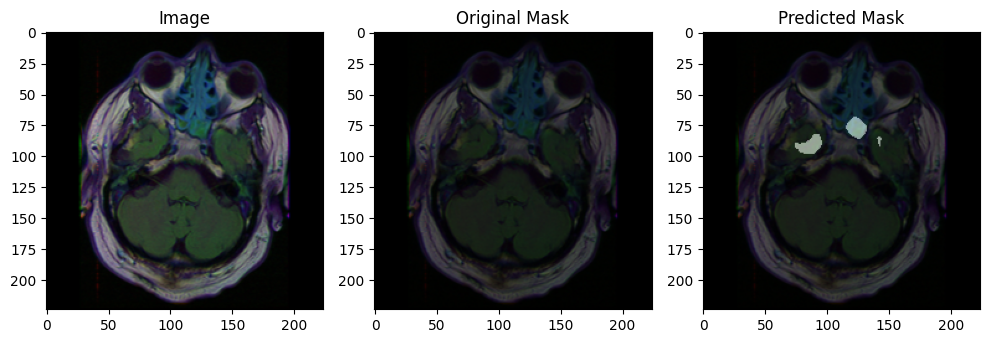

epoch: 2 	step: 1 / 430 	train loss: 0.3820 	train accuracy: 0.9650 	time: 17.2223 s
epoch: 2 	step: 101 / 430 	train loss: 0.2682 	train accuracy: 0.9936 	time: 18.3994 s
epoch: 2 	step: 201 / 430 	train loss: 0.2021 	train accuracy: 0.9921 	time: 16.0189 s
epoch: 2 	step: 301 / 430 	train loss: 0.1673 	train accuracy: 0.9849 	time: 16.1543 s
epoch: 2 	step: 401 / 430 	train loss: 0.1064 	train accuracy: 0.9962 	time: 16.0618 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 2 / 11 	train loss: 0.2066 	valid loss: 0.0976 	train accuracy 0.9906 	valid accuracy 0.9928


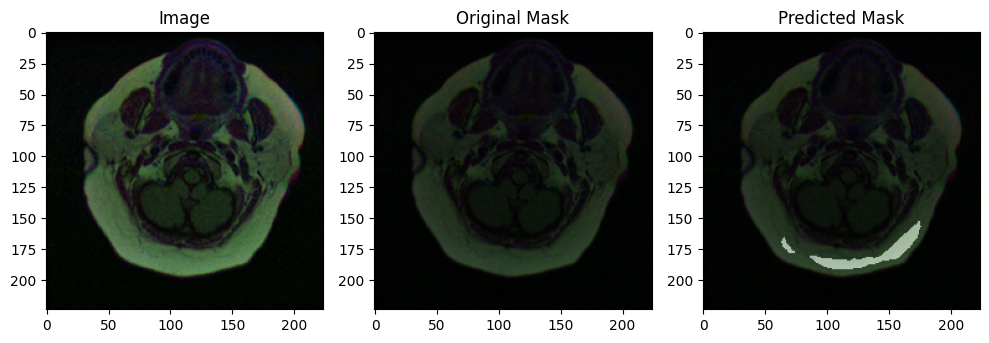

Model saved to: model.pth
epoch: 3 	step: 1 / 430 	train loss: 0.1125 	train accuracy: 0.9890 	time: 16.1619 s
epoch: 3 	step: 101 / 430 	train loss: 0.1115 	train accuracy: 0.9779 	time: 16.1471 s
epoch: 3 	step: 201 / 430 	train loss: 0.0595 	train accuracy: 1.0000 	time: 16.2256 s
epoch: 3 	step: 301 / 430 	train loss: 0.0506 	train accuracy: 0.9985 	time: 15.9666 s
epoch: 3 	step: 401 / 430 	train loss: 0.0630 	train accuracy: 0.9906 	time: 16.0414 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 3 / 11 	train loss: 0.0750 	valid loss: 0.0663 	train accuracy 0.9924 	valid accuracy 0.9913


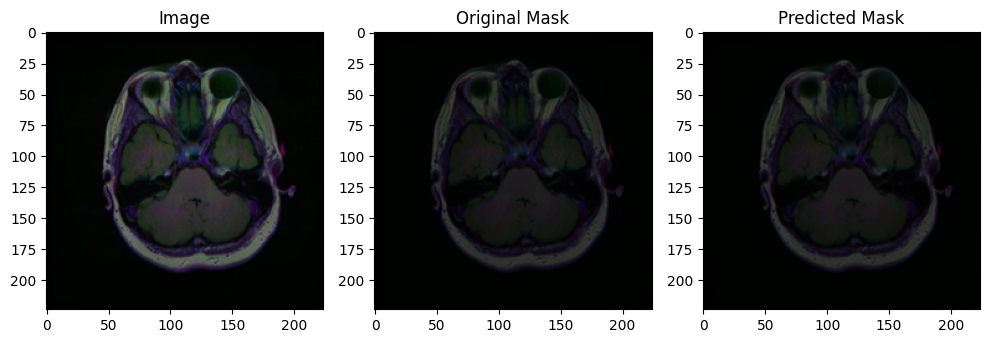

Model saved to: model.pth
epoch: 4 	step: 1 / 430 	train loss: 0.0633 	train accuracy: 0.9911 	time: 16.2748 s
epoch: 4 	step: 101 / 430 	train loss: 0.0489 	train accuracy: 0.9898 	time: 16.2406 s
epoch: 4 	step: 201 / 430 	train loss: 0.0331 	train accuracy: 0.9970 	time: 16.1026 s
epoch: 4 	step: 301 / 430 	train loss: 0.0709 	train accuracy: 0.9776 	time: 16.1103 s
epoch: 4 	step: 401 / 430 	train loss: 0.0553 	train accuracy: 0.9856 	time: 16.3064 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 4 / 11 	train loss: 0.0436 	valid loss: 0.0334 	train accuracy 0.9930 	valid accuracy 0.9939


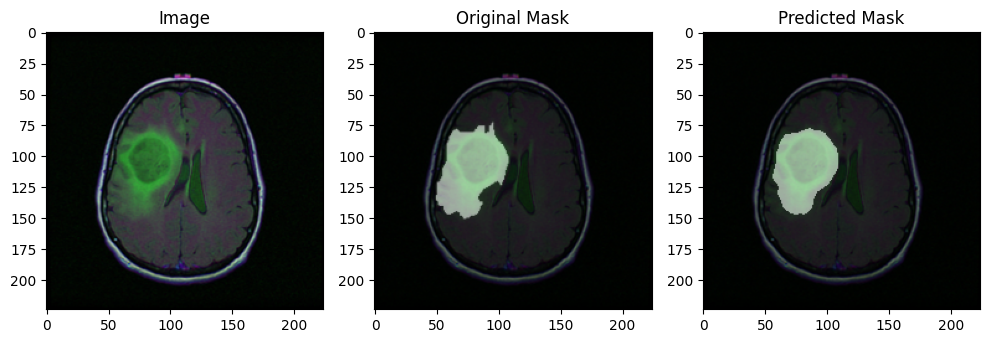

Model saved to: model.pth
epoch: 5 	step: 1 / 430 	train loss: 0.0396 	train accuracy: 0.9932 	time: 16.1860 s
epoch: 5 	step: 101 / 430 	train loss: 0.0504 	train accuracy: 0.9871 	time: 16.0471 s
epoch: 5 	step: 201 / 430 	train loss: 0.0178 	train accuracy: 0.9995 	time: 16.4804 s
epoch: 5 	step: 301 / 430 	train loss: 0.0982 	train accuracy: 0.9722 	time: 16.4158 s
epoch: 5 	step: 401 / 430 	train loss: 0.0182 	train accuracy: 0.9974 	time: 16.3162 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 5 / 11 	train loss: 0.0324 	valid loss: 0.0376 	train accuracy 0.9933 	valid accuracy 0.9919


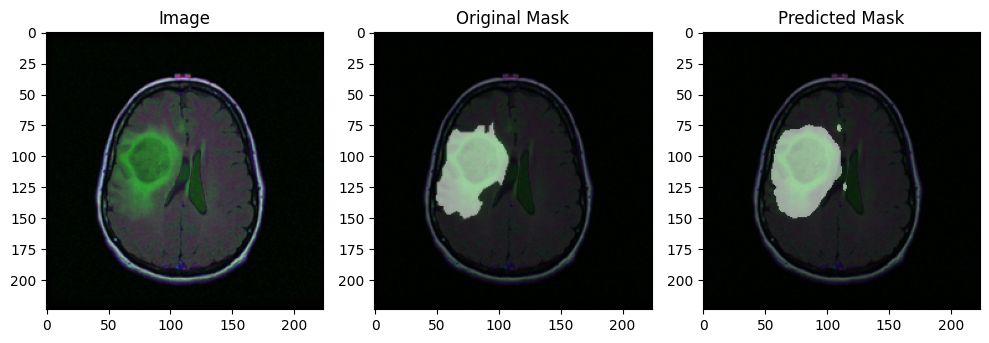

INFO: Early stopping counter 1 of 8
epoch: 6 	step: 1 / 430 	train loss: 0.0227 	train accuracy: 0.9951 	time: 16.7035 s
epoch: 6 	step: 101 / 430 	train loss: 0.0147 	train accuracy: 0.9985 	time: 16.1865 s
epoch: 6 	step: 201 / 430 	train loss: 0.0263 	train accuracy: 0.9935 	time: 15.9892 s
epoch: 6 	step: 301 / 430 	train loss: 0.0153 	train accuracy: 0.9975 	time: 16.1020 s
epoch: 6 	step: 401 / 430 	train loss: 0.0236 	train accuracy: 0.9970 	time: 16.3134 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 6 / 11 	train loss: 0.0281 	valid loss: 0.0255 	train accuracy 0.9933 	valid accuracy 0.9936


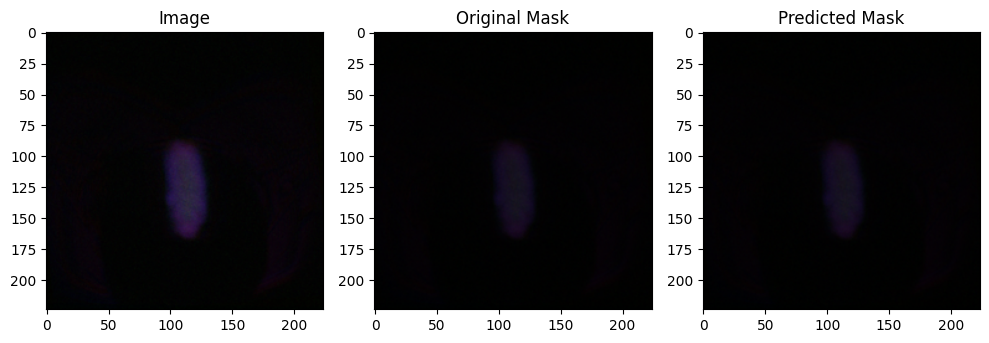

Model saved to: model.pth
epoch: 7 	step: 1 / 430 	train loss: 0.0369 	train accuracy: 0.9898 	time: 16.4159 s
epoch: 7 	step: 101 / 430 	train loss: 0.0139 	train accuracy: 0.9971 	time: 16.1649 s
epoch: 7 	step: 201 / 430 	train loss: 0.0169 	train accuracy: 0.9969 	time: 16.1287 s
epoch: 7 	step: 301 / 430 	train loss: 0.0100 	train accuracy: 0.9986 	time: 16.0286 s
epoch: 7 	step: 401 / 430 	train loss: 0.0522 	train accuracy: 0.9823 	time: 16.0620 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 7 / 11 	train loss: 0.0253 	valid loss: 0.0220 	train accuracy 0.9935 	valid accuracy 0.9942


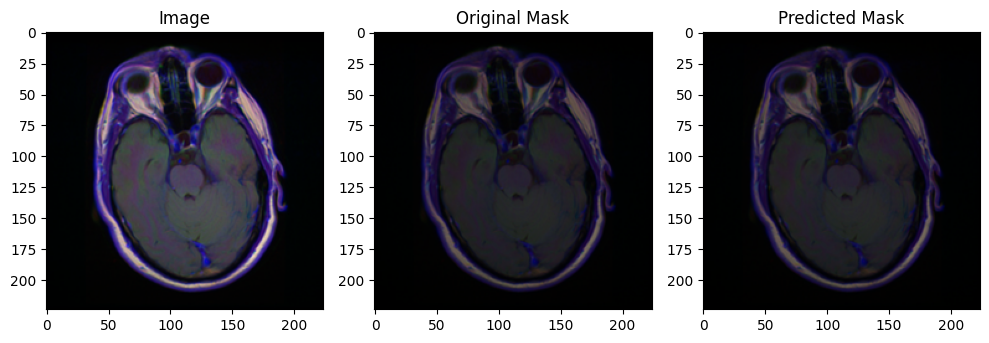

Model saved to: model.pth
epoch: 8 	step: 1 / 430 	train loss: 0.0575 	train accuracy: 0.9858 	time: 16.7628 s
epoch: 8 	step: 101 / 430 	train loss: 0.0340 	train accuracy: 0.9866 	time: 16.3256 s
epoch: 8 	step: 201 / 430 	train loss: 0.0163 	train accuracy: 0.9951 	time: 16.2397 s
epoch: 8 	step: 301 / 430 	train loss: 0.0356 	train accuracy: 0.9896 	time: 16.2107 s
epoch: 8 	step: 401 / 430 	train loss: 0.0266 	train accuracy: 0.9945 	time: 16.4391 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 8 / 11 	train loss: 0.0236 	valid loss: 0.0246 	train accuracy 0.9936 	valid accuracy 0.9936


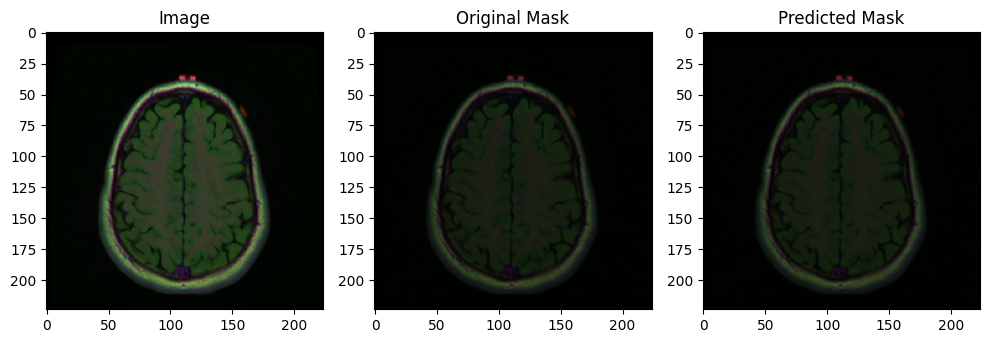

INFO: Early stopping counter 1 of 8
epoch: 9 	step: 1 / 430 	train loss: 0.0267 	train accuracy: 0.9913 	time: 16.3192 s
epoch: 9 	step: 101 / 430 	train loss: 0.0160 	train accuracy: 0.9952 	time: 16.0820 s
epoch: 9 	step: 201 / 430 	train loss: 0.0190 	train accuracy: 0.9932 	time: 16.6330 s
epoch: 9 	step: 301 / 430 	train loss: 0.0181 	train accuracy: 0.9945 	time: 16.5888 s
epoch: 9 	step: 401 / 430 	train loss: 0.0213 	train accuracy: 0.9935 	time: 15.9276 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 9 / 11 	train loss: 0.0207 	valid loss: 0.0189 	train accuracy 0.9941 	valid accuracy 0.9941


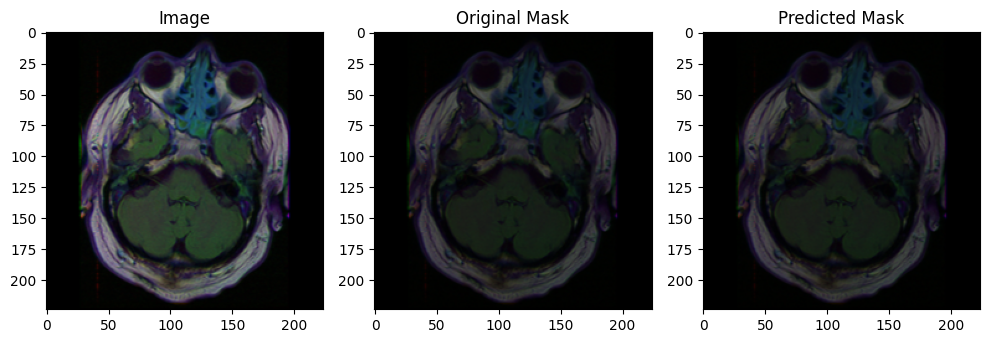

Model saved to: model.pth
epoch: 10 	step: 1 / 430 	train loss: 0.0105 	train accuracy: 0.9980 	time: 16.0356 s
epoch: 10 	step: 101 / 430 	train loss: 0.0309 	train accuracy: 0.9903 	time: 16.1344 s
epoch: 10 	step: 201 / 430 	train loss: 0.0246 	train accuracy: 0.9899 	time: 16.0915 s
epoch: 10 	step: 301 / 430 	train loss: 0.0200 	train accuracy: 0.9942 	time: 15.9686 s
epoch: 10 	step: 401 / 430 	train loss: 0.0130 	train accuracy: 0.9959 	time: 16.4604 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 10 / 11 	train loss: 0.0191 	valid loss: 0.0189 	train accuracy 0.9942 	valid accuracy 0.9947


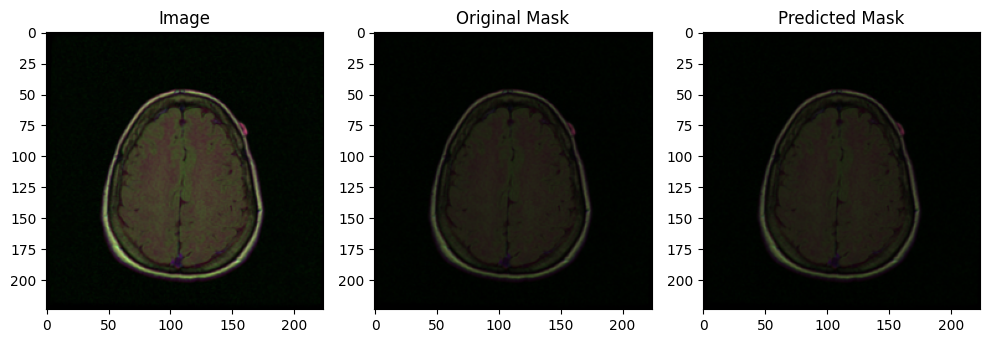

Model saved to: model.pth


In [ ]:
import time

for epoch in range(1, EPOCHS+1):

    train_loss, train_accs = [], []
    for step, batch in enumerate(train_dl):
        time_1 = time.time()

        loss, accuracy = train_one_batch(batch, model, optimizer, criterion)

        train_loss.append(loss)
        train_accs.append(accuracy)

        if step % print_feq == 0:
            print('epoch:', epoch,
                  '\tstep:', step+1, '/', len(train_dl) + 1,
                  '\ttrain loss:', '{:.4f}'.format(loss),
                  '\ttrain accuracy:','{:.4f}'.format(accuracy),
                  '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_feq), 's')

    valid_loss, valid_accs = [], []
    for step, batch in enumerate(tqdm(valid_dl)):
        loss, accuracy = validate_one_batch(batch, model, criterion)

        valid_loss.append(loss)
        valid_accs.append(accuracy)

    print('epoch:', epoch, '/', EPOCHS+1,
            '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
            '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)),
            '\ttrain accuracy', '{:.4f}'.format(np.mean(train_accs)),
            '\tvalid accuracy', '{:.4f}'.format(np.mean(valid_accs)))

    test_plot(model)

    stopper(np.mean(valid_loss))
    scheduler.step(np.mean(valid_loss))